[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/blob/main/07_20_23_day9_causal_modeling/code/diy_notebooks/exercise1.ipynb)


# Causal structure discovery: Y structure
Authors: Iman Wahle and Frederick Eberhardt

In this notebook, we will generate synthetic data from a hand-constructed 
model and use the PC algorithm to infer the underlying model. Since we know
the true underlying model in this case, we will confirm that the method returns
the correct causal structure.

In [66]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('notebook')
from mpl_toolkits.axes_grid1 import make_axes_locatable # for making subplots with colorbars

In [67]:
# colab setup
!pip install -q corner gdown causal-learn
import gdown
gdown.download("https://drive.google.com/uc?export=view&id=1jxir2Cz-_IKtPuBH0ZonRR4ZN0uwCDnf",
               "estimate_parameters.py", quiet=True)

'estimate_parameters.py'

## Generate data

We would like to generate data with the following causal structure: 

![exercise1_model.png](https://drive.google.com/uc?export=view&id=1FYLNXLKw5hVHrpg0dPK9elOa6U9Yu3ZN)

To do this, write a function `generate_data` that takes `n_samples` as an
argument. The data for variables $A$, $B$, $C$, and $D$ should be generated as follows:

- $A = \varepsilon_A$, where $\varepsilon_A \sim \mathcal{N}(0,1)$ 
- $B = \varepsilon_B$, where $\varepsilon_B \sim \mathcal{N}(0,1)$ 
- $C = aA + bB + \varepsilon_C$, where $\varepsilon_C \sim \mathcal{N}(0,1)$ 
- $D = cC + \varepsilon_D$, where $\varepsilon_D \sim \mathcal{N}(0,1)$ 

$a$, $b$, and $c$ are constants you can set to whatever you like.

Once the samples have been generated, z-score the data so that each variable
has a mean of 0 and standard deviation of 1. 

The function should return:

  - `data`: an `n_samples` x 4 numpy array where each column corresponds to
    z-scored samples of $A$, $B$, $C$, and $D$.
  - `var_names` : a list of variable names 

Finally, use your function to generate 5000 samples from this model.

In [68]:
from scipy import stats

def generate_data(n_samples=5000):
    # arbitrary constants for generating data
    a, b, c = 3, 2, 0.5

    data = []
    for _ in range(n_samples):
        var1 = np.random.normal(0, 1)
        var2 = np.random.normal(0, 1)
        var3 = a*var1 + b*var2 + np.random.normal(0, 1)
        var4 = c*var3 + np.random.normal(0, 1)
        data.append([var1, var2, var3, var4])
    data = np.array(data)

    return stats.zscore(data, axis=0), ['A', 'B', 'C', 'D']

data, var_names = generate_data()

## Initial data exploration

Before we begin the analysis, it is important to make sure the data matches
our expectations:

1. Print out the shape of the data and the names of the variables included
2. Construct a [corner plot](https://corner.readthedocs.io/en/latest/pages/quickstart/)
   of the variable distributions
3. Plot the correlation (not covariance) matrix over the four variables
4. Plot the inverse of the correlation matrix (aka the "precision matrix")

In [69]:
# print out data shape and variable names
print(data.shape)
print(var_names)

(5000, 4)
['A', 'B', 'C', 'D']


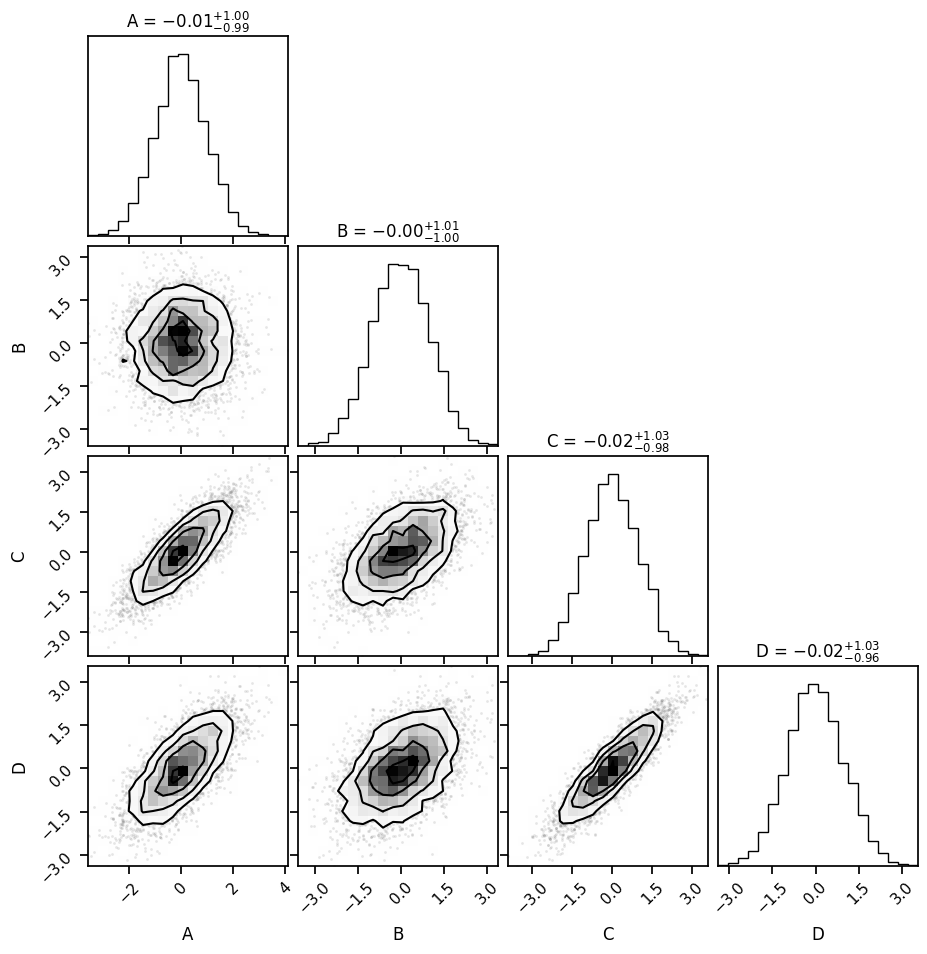

In [70]:
# make a corner plot of the four variables (make sure to include variable name 
# labels!)
# hint: to control the size of the figure, you can construct a plt.figure object
# and pass it in to the corner function as the fig argument

from corner import corner

_ = corner(data, labels=var_names, show_titles=True)

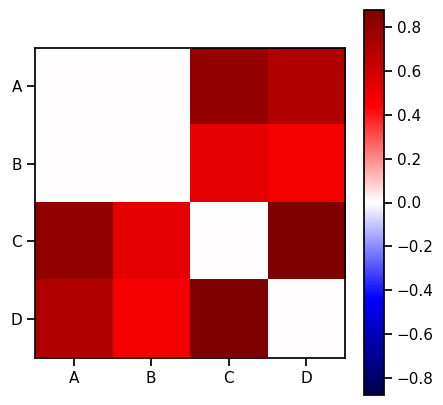

In [71]:
# plot the correlation matrix between the four variables (make sure to include 
# variable name labels!). Set the diagonal terms to 0 so that we can focus 
# on the relationships between variables.

corr = np.corrcoef(data.T)
np.fill_diagonal(corr, 0)
bound = np.max(np.abs(corr))

fig = plt.figure(figsize=(5,5))
plt.imshow(corr, cmap='seismic', vmin=-bound, vmax=bound, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Which entries do we expect to be zero/nonzero in the correlation matrix? 
Confirm that is the case in the plot above.

> All diagonal values (because we set it as so) and the correlation between A and B since they are independently generated from normal distributions

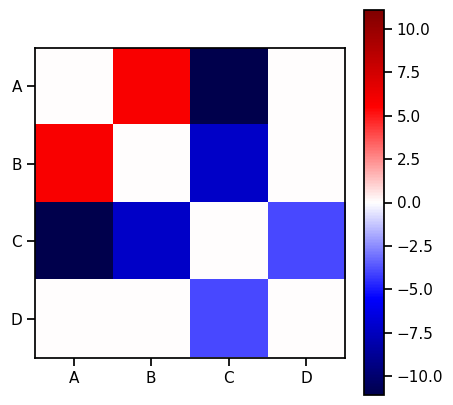

In [72]:
# plot the precision matrix between the four variables (make sure to include 
# variable name labels!). Set the diagonal terms to 0 so that we can focus 
# on the relationships between variables. 

cov = np.cov(data.T)
precision = np.linalg.inv(cov)
np.fill_diagonal(precision, 0)
bound = np.nanmax(np.abs(precision))

fig = plt.figure(figsize=(5,5))
plt.imshow(precision, cmap='seismic', vmin=-bound, vmax=bound, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Which entries do we expect to be zero/nonzero in the precision matrix? 
Confirm that is the case in the plot above.

> A and B are conditionally independent of D, so those cells should be zeros as they are. It's weird that A and B have nonzero interaction cells though. 

## Run the PC algorithm

Now that we have confirmed that our data looks as we expect, we are ready to 
use the PC algorithm to infer the causal graph that gave rise to this data.

As a reminder, the PC algorithm:

1. starts with a fully undirected graph, 
2. deletes edges between pairs of independent nodes, 
3. deletes edges between pairs nodes that are independent when a set of 
   other nodes are conditioned on
4. orients colliders: for any set of nodes X-Y-Z where X and Z are not connected,
   if Y is not in the conditioning set that makes X and Z conditionally 
   independent then X-->Y<--Z
5. orient any other edges that have a clear orientation given that no other
   colliders should be introduced to the graph

<!-- [Image source](https://towardsdatascience.com/causal-discovery-6858f9af6dcb) -->

Today, we will be using the 
[`causal-learn` package](https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html) 
implementation of the PC algorithm. To use this method, we need to set two
parameters:

- `alpha` : this is our p-value threshold for which the function considers two
  variables to be independent 
- `indep_test` : the type of independence test to use 

We will set a variable `cg` equal to the output of the `pc` function called on 
the dataset generated above with `alpha=0.05` and `indep_test='fisherz'` to start. 
Feel free to come back later and try different values for these arguments to 
see how they change the results.

In [73]:
# apply the PC algorithm to our data

from causallearn.search.ConstraintBased.PC import pc

cg = pc(data, alpha=0.05, indep_test='fisherz')

Depth=2, working on node 3: 100%|██████████| 4/4 [00:00<00:00, 954.88it/s] 


In [74]:
# plot the inferred graph using cg.draw_pydot_graph

fig = plt.figure(figsize=(4,4))
cg.draw_pydot_graph(labels=var_names)

FileNotFoundError: [Errno 2] "dot" not found in path.

<Figure size 400x400 with 0 Axes>

Note that even though the PC algorithm generally returns a partially directed
graph, all edges in the graph found above are indeed directed. Why is this the 
case?

> None of the variables influence each other in a bi-directional manner

We can also look at the inferred graph in matrix representation (which is much
easier to understand as the number of variables increases). The matrix 
representation of the partially directed acyclic graph (PDAG) found by the PC
algorithm can be accessed at `cg.G.graph`. The `causal-learn` package 
represents a PDAG with matrix `G` in the following way:

- `G[i,j] = 1` means nodes `i` and `j` are connected with an arrow pointing at `i`
- `G[i,j] = -1` means nodes `i` and `j` are connected with a tail ending at `i`
- `G[i,j] = 0` means nodes `i` and `j` are not connected

Use `plt.imshow` to view this matrix. Make sure to include 
variable labels and to set an appropriate colormap.

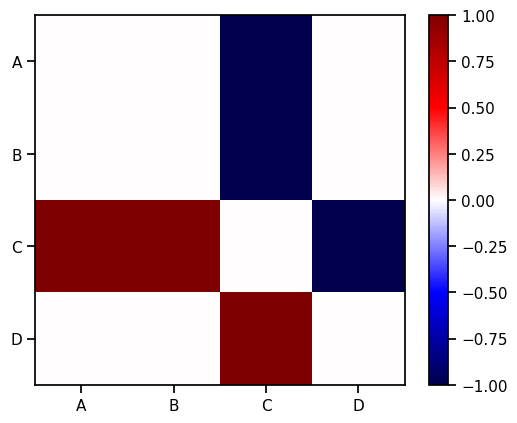

In [75]:
# visualize PDAG matrix representation found by algorithm
pdag_mat = cg.G.graph

plt.imshow(pdag_mat, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

To look at the adjacency matrix as well (which does not contain any information
about edge orientation), convert the matrix representation of the PDAG so that
if there's an edge between nodes `i` and `j`, then `adj_mat[i,j] = 1` and
`adj_mat[j,i] = 1`. Visualize this matrix as well.

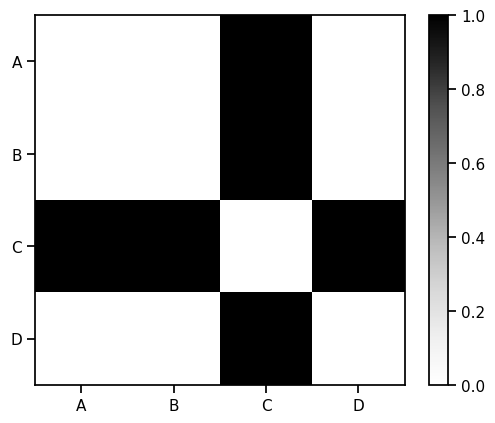

In [76]:
# convert PDAG matrix to adjacency matrix

plt.imshow(np.abs(pdag_mat), cmap='Greys', vmin=0, vmax=1, interpolation='nearest')
plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

## Estimate edge weights and correlation matrix from inferred graph

Now that we have an inferred graph over our variables, we want to see what
correlation matrix we would expect from such a graph and how it compares to 
the correlation matrix computed from our original data. To compute this
correlation matrix, we must first estimate edge weights over the graph.

Normally, if the PC algorithm had only returned a PDAG, we would need to 
convert this to a fully directed acyclic graph (DAG) in order to estimate edge 
weights (this can be any DAG in the equivalence class described by the PDAG). 
In this case, we can skip this step since we already have a DAG.

With this DAG, we can then take each node $j$ in the graph,
find all of its parent nodes $p \in P_j$, and learn weights $\textbf{b}$ such that 
$j = \textbf{b}_1*p_1 + \textbf{b}_2*p_2 + ... + \textbf{b}_k*p_k$, approximately holds.

We can also calculate the sum of squared residuals between $j$ and our estimate:
 $r_j^2 = ||j - \textbf{b}_1*p_1 + \textbf{b}_2*p_2 + ... + \textbf{b}_k*p_k||_2$ to 
 get the error on each node $j$.

Applying these computations to every node $j$ in the graph, we can construct a
matrix $B$ where $B_{ij}$ corresponds to the estimated weight from parent node 
$i$ to node $j$. We can also construct a diagonal matrix $R$ where 
$R_{jj} = r_j^2$ as defined above. 

Use the provided helper function `estimate_parameters` or feel free to write
your own code calculate $B$ and $R$. `estimate_parameters` should return two
variables:
- `edge_params` : an `n_nodes` x `n_nodes` matrix where entry `[i,j]` is equal
  to the edge weight found from node $i$ to $j$. If there is no edge between $i$ 
  and $j$, it equals 0.  
- `residuals` : an `n_nodes` x `n_nodes` diagonal matrix where entry `[j,j]` is
  equal to $r_j^2$.

In [77]:
# estimate edge weights
from estimate_parameters import estimate_parameters
edge_params, residuals = estimate_parameters(pdag_mat, data)

Plot the resulting edge parameters and residuals using `plt.imshow`.

Text(0.5, 1.0, 'Residuals')

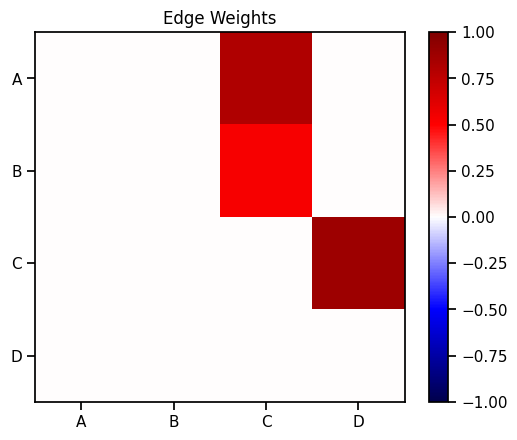

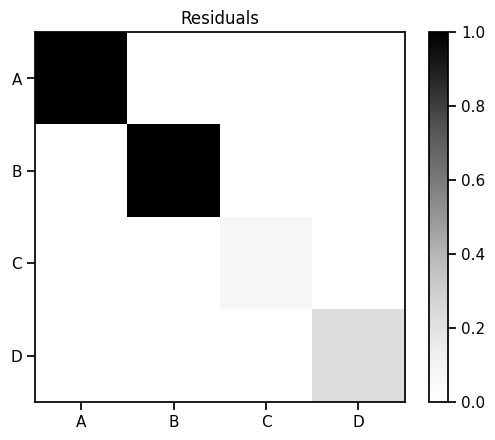

In [78]:
plt.figure(1)
_ = plt.imshow(edge_params, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
_ = plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)
plt.title('Edge Weights')

plt.figure(2)
_ = plt.imshow(residuals, cmap='Greys', vmin=0, vmax=1, interpolation='nearest')
_ = plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)
plt.title('Residuals')

How do the estimated weights and residuals compare to the original data 
generation model? What may explain any differences?

>Answer here

Lastly, we will estimate the correlation matrix for the graph structure
and edge weights that we found and compare to the correlation matrix we 
calculated at the beginning from the actual data. Given the edge weights
and residuals found above, the resulting *covariance* matrix is given by: 
$C = (I-B)^{-1} R (I-B)^{-T}$, where $I$ is the identity matrix, $B$ is the matrix of
edge weights between every pair of nodes $(i,j)$, and $R$ is the diagonal matrix of
squared residuals.
Note that the relationship between correlation and covariance is: 
$corr_{i,j} = cov_{i,j}/(\sigma_i\sigma_j)$, so each entry $(i,j)$ in the 
estimated covariance should be normalized by $\sigma_i\sigma_j$.

Write a function `get_correlation_matrix` that implements the above to
return the estimated correlation matrix.

In [91]:
from estimate_parameters import get_correlation_matrix

est_corr = get_correlation_matrix(edge_params, residuals)

Plot the estimated correlation matrix (zero out the diagonal).

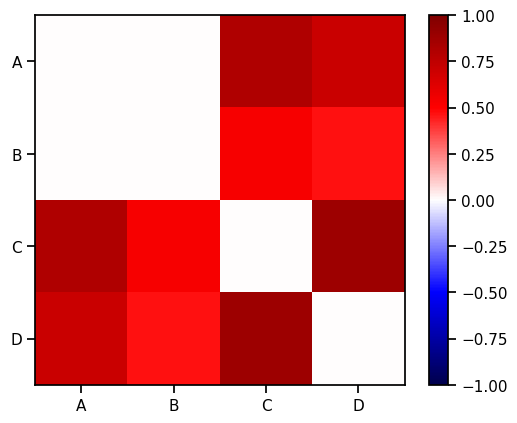

In [92]:
np.fill_diagonal(est_corr, 0)

_ = plt.imshow(est_corr, cmap='seismic', vmin=-1, vmax=1, interpolation='nearest')
_ = plt.colorbar()
plt.gca().set_xticks(range(len(var_names)))
plt.gca().set_yticks(range(len(var_names)))
_ = plt.gca().set_xticklabels(var_names)
_ = plt.gca().set_yticklabels(var_names)

Quantify how closely the estimated correlation matrix matches that found
from the data. To do this, vectorize the lower-triangular elements in the true
and estimated matrices and compute the Pearson correlation between the two vectors.

`np.corrcoef` and `np.tril_indices` may be useful here.

In [96]:
true_vec = corr[np.tril_indices(corr.shape[0], k=-1)].flatten()
est_vec = est_corr[np.tril_indices(est_corr.shape[0],-1)].flatten()
print(np.corrcoef(true_vec, est_vec)[0,1])

0.9999674672606058
